<a href="https://colab.research.google.com/github/sgarciarod/AlgorithmsUN2024II/blob/master/LabATQ/sgarciarod_LAB_ATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [2]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-upsydkpo
  Resolved https://github.com/quantiacs/toolbox.git to commit 272e66e017d3eb6d40517ffa39cd6a92dc5072d8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 12.2 MB/s eta 0:00:00
  Created wheel for qnt: filename=qnt-0.0.407-py3-none-any.whl size=115361 sha256=a56424f906f1885572aba22dbaefd1986860e8cb5dda1e345e2e0f85007388d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_tbvfsqd/wheels/ca/03/48/1dbd01eee19642348a025488a55e2290c63d6b83473b2b8b9a
Successfully built qnt
  Attempt

In [3]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139    0  4139    0     0  13661      0 --:--:-- --:--:-- --:--:-- 13705
100  517k  100  517k    0     0   632k      0 --:--:-- --:--:-- --:--:-- 2340k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0  10964      0 --:--:-- --:--:-- --:--:-- 10991
100  392k  100  392k    0     0   403k      0 --:--:-- --:--:-- --:--:-- 1052k


In [4]:
import os

os.environ['API_KEY'] = '2321659b-87c9-449f-ae8e-007643da74cb'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'


In [5]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

# Se elige la RandomFOrestRegressor por su capacidad para modelar relaciones no lineales y su robustez al sobreajuste.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [6]:
import qnt.data as qndata
data = qndata.cryptofutures.load_data(tail=365*7)

| |  #                                            | 61891 Elapsed Time: 0:00:00


In [7]:
open  = data.sel(field='open')
close = data.sel(field='close')
high  = data.sel(field='high')
low   = data.sel(field='low')

volume_day    = data.sel(field='vol')
open_interest = data.sel(field='oi')

contracts_roll_over = data.sel(field='roll')


In [8]:
# Cargar todos los activos del S&P 500
stock_data = qndata.stocks.load_spx_data(tail=365 * 5, assets = [
    "NAS:AAPL", "NAS:MSFT", "NAS:GOOGL", "NAS:NVDA", "NAS:META",
    "NAS:TSLA", "NAS:AMZN", "NYS:UNH", "NYS:JNJ", "NYS:JPM",
    "NYS:V", "NYS:XOM", "NYS:NEE", "NYS:PG", "NYS:KO",
    "NAS:COST", "NAS:CSCO", "NYS:NKE", "NYS:DIS", "NYS:WM"
])

# Se eligen empresas con alta capitalización, liquidez, y relevancia en sus industrias.

# Activos seleccionados:
# 1. AAPL, MSFT, GOOGL, NVDA, META (Tecnología): Lideran la innovación en sus campos.
# 2. TSLA, AMZN, COST (Consumo discrecional): Líderes en comercio y tecnología de consumo.
# 3. UNH, JNJ (Salud): Compañías dominantes en servicios médicos y productos farmacéuticos.
# 4. JPM, V (Finanzas): Bancos y pagos digitales con alta liquidez.
# 5. XOM, NEE (Energía): Diversificación entre petróleo y energías renovables.
# 6. PG, KO (Bienes de consumo): Marcas globales con productos esenciales.
# 7. DIS (Comunicación): Entretenimiento y medios globalmente reconocidos.
# 8. WM (Servicios públicos): Sostenibilidad y gestión de residuos.

# Justificación:
    # - Diversificación sectorial: Mitiga riesgos al cubrir distintos sectores.
    # - Alta capitalización y liquidez: Empresas dominantes con alta negociación.
    # - Relevancia y sostenibilidad: Adaptabilidad al futuro y crecimiento continuo.
    # - Reconocimiento global: Confianza y estabilidad en el mercado.



| | #                                             | 15975 Elapsed Time: 0:00:00
| | #                                             | 15975 Elapsed Time: 0:00:00
| |      #                                       | 472441 Elapsed Time: 0:00:00


fetched chunk 1/1 1s
Data loaded 3s


In [9]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
    macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    price = price.assign_coords(field="price")

    # ATR (Average True Range)
    true_range = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    atr = qnta.lwma(true_range, 14)
    atr = atr.assign_coords(field="atr")
    # El ATR cuantifica la volatilidad del mercado evaluando el rango promedio de precios durante un período determinado.

    # EMA (Exponential Moving Average)
    ema = qnta.ema(data.sel(field="close"), 20)
    ema = ema.assign_coords(field="ema")
    # La EMA asigna mayor peso a los precios recientes, lo que permite captar cambios en la tendencia con mayor sensibilidad.

    # On-Balance Volume
    if 'volume' in data.field:
        obv = data.sel(field="close")
        volume = data.sel(field="volume")
        obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
    else:
        # If 'volume' is not present, fill with 1s
        obv = xr.ones_like(data.sel(field="close"))
    obv = obv.assign_coords(field="obv")
    #  El OBV calcula el volumen acumulado ponderado por el movimiento del precio, identificando tendencias respaldadas por el flujo de volumen.

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal, volatility,  d, rsi, price, atr, ema, obv],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "atr", "ema", "obv"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [10]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:DIS,NYS:JNJ,NYS:JPM,NYS:KO,NYS:NEE,NYS:NKE,NYS:PG,NYS:UNH,NYS:V,NYS:WM,NYS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-0.011361,0.148505,0.011816,0.048021,0.249237,0.145847,-0.062986,-0.091217,0.471529,0.041569,-0.244568,0.040052,-0.165069,-0.398167,-0.266453,-0.216872,-0.238077,0.024832,-0.113789,-0.256135
2025-01-13,-0.045787,0.133135,-0.033290,0.044948,0.222222,0.101990,-0.076418,-0.153545,0.517715,0.017968,-0.184979,0.095016,-0.127068,-0.406901,-0.221871,-0.207411,-0.107154,0.011768,-0.107997,-0.167927
2025-01-14,-0.061104,0.114669,-0.060912,0.072444,0.190155,0.022690,-0.087875,-0.189081,0.429627,0.012321,-0.171939,0.134368,-0.099325,-0.351431,-0.254371,-0.185597,-0.090094,0.029759,-0.112059,-0.150235


In [11]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up more than 0.1%
    class_neutral = 0 # prices goes up or don las that 0.1%
    class_negative = -1 # price goes down more than 0.1%

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [12]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:DIS,NYS:JNJ,NYS:JPM,NYS:KO,NYS:NEE,NYS:NKE,NYS:PG,NYS:UNH,NYS:V,NYS:WM,NYS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-22,1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,1,-1,-1,-1,-1,1,-1
2020-01-23,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1
2020-01-24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,1,-1,-1,1,-1
2020-01-27,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,-1,-1
2020-01-28,1,1,-1,-1,1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-1,-1,-1,1,-1,-1,-1,-1,1,-1,1,1,1,-1,1,1,1,-1,1,1
2025-01-13,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,1,1,1,-1,1
2025-01-14,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1


In [13]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    model = RandomForestRegressor()
    return model

In [14]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(), 'NAS:AMZN': RandomForestRegressor(), 'NAS:COST': RandomForestRegressor(), 'NAS:CSCO': RandomForestRegressor(), 'NAS:GOOGL': RandomForestRegressor(), 'NAS:META': RandomForestRegressor(), 'NAS:MSFT': RandomForestRegressor(), 'NAS:NVDA': RandomForestRegressor(), 'NAS:TSLA': RandomForestRegressor(), 'NYS:DIS': RandomForestRegressor(), 'NYS:JNJ': RandomForestRegressor(), 'NYS:JPM': RandomForestRegressor(), 'NYS:KO': RandomForestRegressor(), 'NYS:NEE': RandomForestRegressor(), 'NYS:NKE': RandomForestRegressor(), 'NYS:PG': RandomForestRegressor(), 'NYS:UNH': RandomForestRegressor(), 'NYS:V': RandomForestRegressor(), 'NYS:WM': RandomForestRegressor(), 'NYS:XOM': RandomForestRegressor()}


Feature: 0, Score: 0.12648
Feature: 1, Score: 0.13554
Feature: 2, Score: 0.11877
Feature: 3, Score: 0.15609
Feature: 4, Score: 0.14505
Feature: 5, Score: 0.09100
Feature: 6, Score: 0.12966
Feature: 7, Score: 0.09741
Feature: 8, Score: 0.00000


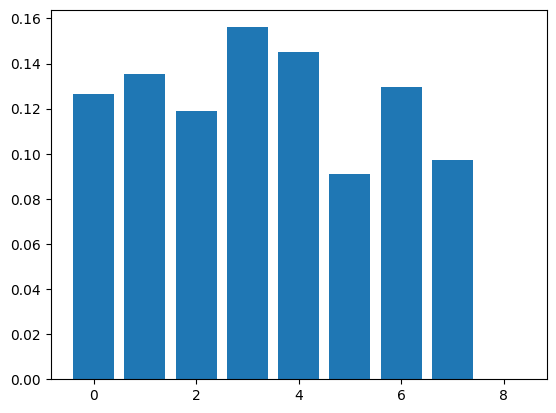

In [15]:
# Showing which features are more important in predicting:

# Changed the asset name from 'NAS:APPL' to 'NAS:AAPL'
importance = models["NAS:META"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [16]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="is_liquid"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 20)> Size: 201kB
array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.36,  0.52,  0.46, ...,  0.52,  0.68,  0.68],
       [-0.8 , -0.76, -0.92, ...,  0.66,  0.62, -0.78],
       [-0.64, -0.62, -0.6 , ..., -0.32, -0.54, -0.76]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:AMZN' ... 'NYS:WM' 'NYS:XOM'
  * time     (time) datetime64[ns] 10kB 2020-01-22 2020-01-23 ... 2025-01-16
    field    <U9 36B 'is_liquid'


<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-16-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [17]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

61.247657981950894

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [18]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-10,28486.384577,0.006887,0.112544,0.0,-0.028037,61.262480,6.894725,-0.018923,20.0,0.963652,1.966251
2025-01-13,28673.837249,0.006580,0.112502,0.0,-0.028037,61.262426,6.892119,-0.023401,20.0,0.963776,1.965843
2025-01-14,28901.577675,0.007942,0.112457,0.0,-0.028037,61.282791,6.891664,0.637343,20.0,0.963508,1.966077
2025-01-15,28902.027577,0.000016,0.112473,0.0,-0.028037,61.158916,6.878699,-0.342817,20.0,0.963751,1.966646
2025-01-16,29306.705455,0.014002,0.112457,0.0,-0.028037,61.247658,6.887743,-1.000000,20.0,0.964130,1.965936


time,2025-01-16
field,
sharpe_ratio,61.247658


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [19]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.8101015690735668

In [20]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.8101485306785101

In [21]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.3876318725099598

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [22]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [23]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="is_liquid"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [24]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |          #                                  | 2298686 Elapsed Time: 0:00:01


fetched chunk 1/1 5s
Data loaded 6s


<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 6s
Data loaded 6s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |            #                                | 2173152 Elapsed Time: 0:00:01


fetched chunk 1/1 6s
Data loaded 6s


<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...


<ipython-input-23-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

| |#                                               | 9060 Elapsed Time: 0:00:00
| |            #                                | 2760517 Elapsed Time: 0:00:01


fetched chunk 1/8 3s


| |            #                                | 2777988 Elapsed Time: 0:00:01


fetched chunk 2/8 6s


| |            #                                | 2586056 Elapsed Time: 0:00:01


fetched chunk 3/8 9s


| |             #                               | 3060203 Elapsed Time: 0:00:01


fetched chunk 4/8 16s


| |            #                                | 3178528 Elapsed Time: 0:00:01


fetched chunk 5/8 18s


| |             #                               | 3388072 Elapsed Time: 0:00:01


fetched chunk 6/8 21s


| |            #                                | 3554948 Elapsed Time: 0:00:01


fetched chunk 7/8 24s


| |             #                               | 3173274 Elapsed Time: 0:00:01


fetched chunk 8/8 27s
Data loaded 32s


| |#                                               | 9060 Elapsed Time: 0:00:00
| |            #                                | 2794368 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |            #                                | 2925930 Elapsed Time: 0:00:01


fetched chunk 2/7 6s


| |            #                                | 2876646 Elapsed Time: 0:00:01


fetched chunk 3/7 8s


| |             #                               | 3057713 Elapsed Time: 0:00:01


fetched chunk 4/7 11s


| |            #                                | 3346807 Elapsed Time: 0:00:01


fetched chunk 5/7 14s


| |                  #                          | 3493824 Elapsed Time: 0:00:01


fetched chunk 6/7 18s


| |              #                              | 3203764 Elapsed Time: 0:00:01


fetched chunk 7/7 21s
Data loaded 21s
Backtest...


Se truncaron las últimas líneas 5000 del resultado de transmisión.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-22-3636d5c2d255>:13: Futu

fetched chunk 1/7 3s


| |            #                                | 2944277 Elapsed Time: 0:00:01


fetched chunk 2/7 5s


| |            #                                | 2892775 Elapsed Time: 0:00:01


fetched chunk 3/7 8s


| |            #                                | 3079676 Elapsed Time: 0:00:01


fetched chunk 4/7 11s


| |            #                                | 3376191 Elapsed Time: 0:00:01


fetched chunk 5/7 14s


| |              #                              | 3523585 Elapsed Time: 0:00:01


fetched chunk 6/7 17s


| |             #                               | 3230664 Elapsed Time: 0:00:01


fetched chunk 7/7 21s
Data loaded 21s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-16
Sharpe Ratio = -1.6589747521776699


ERROR! The Sharpe Ratio is too low. -1.6589747521776699 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5043 of 5043) |####################| Elapsed Time: 0:11:04 Time:  0:11:04


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.